In [47]:
from dir import *
from VAE_model import *
from VAE_model_single import *
from VAE_MoG_model import *
from training import *
from extras import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from scipy.stats import shapiro
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import itertools
plt.style.use('ggplot')

# 1) Data exploration 

## 1.1) Overall exporation 

In [48]:
data = pd.read_csv(PANGENOME_MATRIX_CSV, index_col=[0], header=[0])

In [49]:
phylogroup_data = pd.read_csv(PHYLOGROUPS_DATA, index_col=[0], header=[0])

In [50]:
phylogroup_data

,Phylogroup
AccessionID,
GCF_000005845,A
GCF_000007445,B2
GCF_000008865,E
GCF_000009565,A
GCF_000010245,A
...,...
GCF_904866495,D
GCF_905071835,F
GCF_905071865,A


In [51]:
data

,GCF_009363035,GCF_016889545,GCF_008065455,GCF_015135355,GCF_000026545,GCF_002012065,GCF_009650175,GCF_016903815,GCF_005221505,GCF_001559655,...,GCF_010365525,GCF_009832985,GCF_013374295,GCF_014168955,GCF_011769865,GCF_000725305,GCF_008124285,GCF_017165375,GCF_001663075,GCF_000022665
GF_ID,,,,,,,,,,,,,,,,,,,,,
GF_1,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
GF_2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GF_3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GF_4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GF_5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GF_31460,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
GF_31461,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
GF_31462,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [52]:
data.dtypes

GCF_009363035    int64
GCF_016889545    int64
GCF_008065455    int64
GCF_015135355    int64
GCF_000026545    int64
                 ...  
GCF_000725305    int64
GCF_008124285    int64
GCF_017165375    int64
GCF_001663075    int64
GCF_000022665    int64
Length: 1324, dtype: object

In [53]:
data.transpose()

GF_ID,GF_1,GF_2,GF_3,GF_4,GF_5,GF_6,GF_7,GF_8,GF_9,GF_10,...,GF_31455,GF_31456,GF_31457,GF_31458,GF_31459,GF_31460,GF_31461,GF_31462,GF_31464,GF_31465
GCF_009363035,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
GCF_016889545,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
GCF_008065455,0,0,1,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
GCF_015135355,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
GCF_000026545,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCF_000725305,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
GCF_008124285,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
GCF_017165375,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
GCF_001663075,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [54]:
data.transpose()[data.transpose()[data.transpose().columns].eq(0).all(1)]

GF_ID,GF_1,GF_2,GF_3,GF_4,GF_5,GF_6,GF_7,GF_8,GF_9,GF_10,...,GF_31455,GF_31456,GF_31457,GF_31458,GF_31459,GF_31460,GF_31461,GF_31462,GF_31464,GF_31465


In [55]:
data.columns

Index(['GCF_009363035', 'GCF_016889545', 'GCF_008065455', 'GCF_015135355',
       'GCF_000026545', 'GCF_002012065', 'GCF_009650175', 'GCF_016903815',
       'GCF_005221505', 'GCF_001559655',
       ...
       'GCF_010365525', 'GCF_009832985', 'GCF_013374295', 'GCF_014168955',
       'GCF_011769865', 'GCF_000725305', 'GCF_008124285', 'GCF_017165375',
       'GCF_001663075', 'GCF_000022665'],
      dtype='object', length=1324)

In [56]:
percent_GF_present = data.astype(bool).sum(axis=0) / len(data.index) * 100

In [57]:
percent_GF_present

GCF_009363035    16.990559
GCF_016889545    16.372935
GCF_008065455    16.585366
GCF_015135355    16.443745
GCF_000026545    17.053501
                   ...    
GCF_000725305    15.609756
GCF_008124285    15.778914
GCF_017165375    17.816680
GCF_001663075    15.243902
GCF_000022665    15.062943
Length: 1324, dtype: float64

In [58]:
# plt.figure(figsize=(10, 8))
# percent_GF_present.iloc[:100].plot(kind='bar', color='dodgerblue')
# plt.xlabel('Genomes')
# plt.ylabel('Percentage of GFs present in the genome')
# plt.show()

In [59]:
frequency1 = data.sum(axis=1)

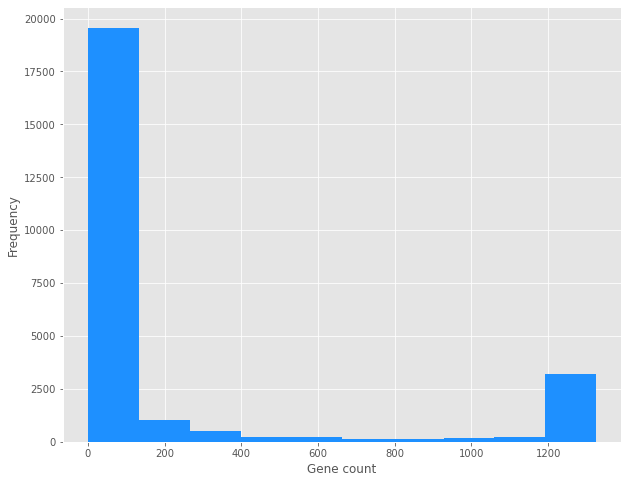

In [60]:
plt.figure(figsize=(10,8))
plt.hist(frequency1, color='dodgerblue')
plt.xlabel('Gene count')
plt.ylabel('Frequency')
plt.savefig("figures/gene_count.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [61]:
frequency2 = data.sum(0)

In [62]:
frequency2

GCF_009363035    4319
GCF_016889545    4162
GCF_008065455    4216
GCF_015135355    4180
GCF_000026545    4335
                 ... 
GCF_000725305    3968
GCF_008124285    4011
GCF_017165375    4529
GCF_001663075    3875
GCF_000022665    3829
Length: 1324, dtype: int64

In [63]:
# plt.figure(figsize=(10,8))
# plt.hist(frequency2, bin=20, color='dodgerblue')
# plt.xlabel('Genome size')
# plt.ylabel('Gene Gamily Frequency')
# plt.savefig("figures/genome_size.pdf", format="pdf", bbox_inches="tight")
# plt.show()

In [64]:
threshold_data = []
thresholds = np.linspace(0, 20, num=10)

for i in thresholds:
    row_sums = data.sum(axis=1)
    threshold_data.append(len(data[row_sums >= i]))

In [65]:
threshold_data

[25420, 17020, 14507, 13058, 12127, 11221, 10721, 10330, 10005, 9730]

In [66]:
thresholds

array([ 0.        ,  2.22222222,  4.44444444,  6.66666667,  8.88888889,
       11.11111111, 13.33333333, 15.55555556, 17.77777778, 20.        ])

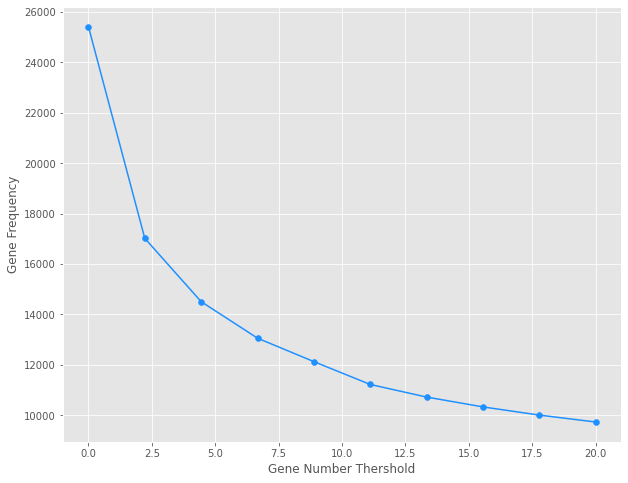

In [67]:
plt.figure(figsize=(10,8))
plt.scatter(thresholds, threshold_data, color='dodgerblue')
plt.plot(thresholds, threshold_data, color='dodgerblue')
plt.xlabel('Gene Number Thershold')
plt.ylabel('Gene Frequency')
plt.savefig("figures/gene_frequency.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [68]:
data.transpose()

GF_ID,GF_1,GF_2,GF_3,GF_4,GF_5,GF_6,GF_7,GF_8,GF_9,GF_10,...,GF_31455,GF_31456,GF_31457,GF_31458,GF_31459,GF_31460,GF_31461,GF_31462,GF_31464,GF_31465
GCF_009363035,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
GCF_016889545,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
GCF_008065455,0,0,1,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
GCF_015135355,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
GCF_000026545,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCF_000725305,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
GCF_008124285,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
GCF_017165375,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
GCF_001663075,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


## 1.2) PCA

In [69]:
merged_df = pd.merge(data.transpose(), phylogroup_data, how='inner', left_index=True, right_on='AccessionID')

In [70]:
merged_df

,GF_1,GF_2,GF_3,GF_4,GF_5,GF_6,GF_7,GF_8,GF_9,GF_10,...,GF_31456,GF_31457,GF_31458,GF_31459,GF_31460,GF_31461,GF_31462,GF_31464,GF_31465,Phylogroup
AccessionID,,,,,,,,,,,,,,,,,,,,,
GCF_009363035,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,A
GCF_016889545,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,A
GCF_008065455,0,0,1,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,A
GCF_015135355,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,B1
GCF_000026545,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,B2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCF_000725305,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,A
GCF_008124285,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,A
GCF_017165375,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,E


In [71]:
# Apply PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(merged_df.iloc[:, :-1])
df_pca = pd.DataFrame(data_pca, columns=['PC1', 'PC2'])

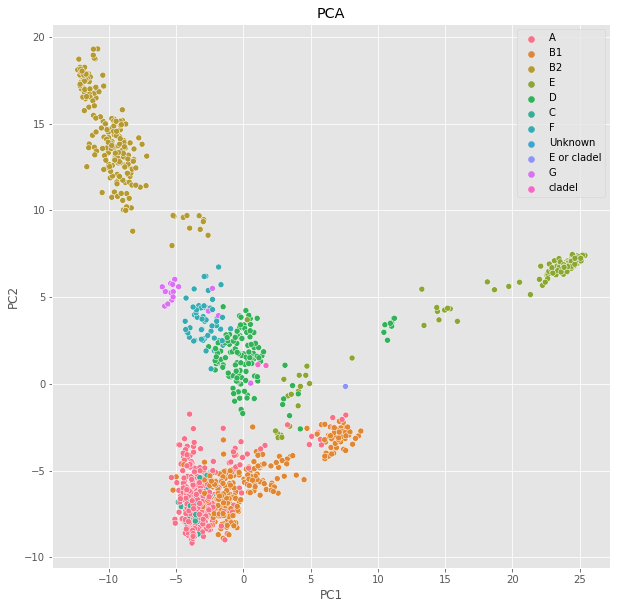

In [72]:
# Visualize the first two principal components
plt.figure(figsize=(10, 10))
sns.scatterplot(x='PC1', y='PC2', hue = merged_df.Phylogroup.tolist(), data=df_pca)
plt.title('PCA')
plt.savefig("figures/PCA_graph.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [73]:
df_pca

,PC1,PC2
0,-3.560677,-6.627116
1,-2.650110,-7.136572
2,-0.299936,-6.008099
3,-4.996945,-5.365164
4,-2.953077,9.467883
...,...,...
1319,-4.086980,-7.939809
1320,-2.994488,-7.807338
1321,24.643630,7.241193
1322,-3.746871,-8.790186


In [74]:
shapiro_test_pc1 = shapiro(df_pca['PC1'])
shapiro_test_pc2 = shapiro(df_pca['PC2'])
print(f"Shapiro-Wilk Test for PC1: {shapiro_test_pc1}")
print(f"Shapiro-Wilk Test for PC2: {shapiro_test_pc2}")

Shapiro-Wilk Test for PC1: ShapiroResult(statistic=0.7767663598060608, pvalue=4.115196002779619e-39)
Shapiro-Wilk Test for PC2: ShapiroResult(statistic=0.8642287254333496, pvalue=2.3321049726457904e-32)


# 2) Data preprocessing  

In [117]:
merged_df

,GF_1,GF_2,GF_3,GF_4,GF_5,GF_6,GF_7,GF_8,GF_9,GF_10,...,GF_31456,GF_31457,GF_31458,GF_31459,GF_31460,GF_31461,GF_31462,GF_31464,GF_31465,Phylogroup
AccessionID,,,,,,,,,,,,,,,,,,,,,
GCF_009363035,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,A
GCF_016889545,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,A
GCF_008065455,0,0,1,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,A
GCF_015135355,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,B1
GCF_000026545,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,B2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCF_000725305,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,A
GCF_008124285,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,A
GCF_017165375,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,E


In [75]:
numeric_cols = merged_df.select_dtypes(include='number')
column_sums = numeric_cols.sum(axis=0)

filtered_columns = column_sums[column_sums >= 20].index
filtered_data = merged_df[filtered_columns]

filtered_data = merged_df[filtered_columns].copy()
filtered_data['Phylogroup'] = merged_df['Phylogroup']

In [76]:
filtered_data

,GF_1,GF_4,GF_14,GF_17,GF_18,GF_19,GF_20,GF_21,GF_22,GF_23,...,GF_31456,GF_31457,GF_31458,GF_31459,GF_31460,GF_31461,GF_31462,GF_31464,GF_31465,Phylogroup
AccessionID,,,,,,,,,,,,,,,,,,,,,
GCF_009363035,0,0,0,0,0,0,0,1,0,0,...,1,1,1,1,1,1,1,1,1,A
GCF_016889545,0,0,0,0,0,0,0,0,1,0,...,1,1,1,1,1,1,1,1,1,A
GCF_008065455,0,0,0,0,0,1,0,0,1,0,...,1,1,1,1,1,1,1,1,1,A
GCF_015135355,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,B1
GCF_000026545,0,0,0,1,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,B2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCF_000725305,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,A
GCF_008124285,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,A
GCF_017165375,0,0,0,0,0,0,1,0,0,0,...,1,1,1,1,1,1,1,1,1,E


In [77]:
data_array_t = np.array(filtered_data.iloc[:, :-1])
phylogroups_array = np.array(filtered_data.iloc[:, -1])

In [78]:
data_array_t

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]])

In [79]:
phylogroups_array

array(['A', 'A', 'A', ..., 'E', 'A', 'A'], dtype=object)

In [80]:
data_array_t.shape

(1324, 9730)

In [81]:
data_array_t.shape[1]

9730

In [90]:
# Converting to PyTorch tensor
data_tensor = torch.tensor(data_array_t, dtype=torch.float32)

# Spliting into train and test sets
train_data, temp_data, train_labels, temp_labels = train_test_split(data_tensor, phylogroups_array, test_size=0.3, random_state=12345)
val_data, test_data, val_labels, test_labels = train_test_split(temp_data, temp_labels, test_size=0.3333, random_state=12345)

# train_data, val_data = train_test_split(data_tensor, test_size=0.2, random_state=12345)
# train_data, test_data = train_test_split(data_tensor, test_size=0.25, random_state=12345)

test_phylogroups = test_labels

# train_labels = torch.tensor(train_labels, dtype=torch.long)
# val_labels = torch.tensor(val_labels, dtype=torch.long)
# test_labels = torch.tensor(test_labels, dtype=torch.long)

# TensorDataset
train_dataset = TensorDataset(train_data)
val_dataset = TensorDataset(val_data)
test_dataset = TensorDataset(test_data)

# DataLoaders for main training
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Dataloader for overfitting on one sample (for dubbiging purposes)
input_dim = filtered_data.shape[1]
binary_data = torch.tensor(np.random.randint(0, 2, size=(1, input_dim)), dtype=torch.float32)
single_sample_dataset = TensorDataset(binary_data)
single_sample_loader = DataLoader(single_sample_dataset, batch_size=1, shuffle=True)

# Dataloader fot a small subset for overfitting (again, for debugging)
small_subset_indices = np.random.choice(len(train_dataset), size=256, replace=False)
small_subset = Subset(train_dataset, small_subset_indices)
small_loader = DataLoader(small_subset, batch_size=batch_size, shuffle=True)

In [89]:
len(test_data)

265

In [88]:
len(test_phylogroups)

265

In [ ]:
len(train_dataset)

In [ ]:
len(train_loader)

In [ ]:
len(train_dataset)

In [ ]:
len(val_dataset)

In [ ]:
train_data

In [ ]:
TensorDataset(train_data)

In [ ]:
TensorDataset(torch.tensor(train_data))

In [ ]:
print(data_tensor)

# 3) Overfitting on a single sample and small data subset

## 3.1) Overfitting on a single sample

In [ ]:
single_sample = torch.randn(1, data_array_t.shape[1])

In [ ]:
single_sample.shape[0]

In [ ]:
# NO GRADIENT CLIPPING AND SCHEDULER 
hidden_dim = 512
latent_dim = 64
beta_start = 0.1
beta_end = 1.0
n_epochs = 10

model = VAE_single(input_dim, hidden_dim, latent_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Overfitting one sample to see if the model is broken 
model.train()
num_epochs = 1000

# Collecting data for visualisation 
train_loss_vals1 = []
train_loss_vals2 = []
kl_divergences_no_beta = []
kl_divergences_beta = []

for epoch in range(num_epochs):
    beta = beta_start + (beta_end - beta_start) * epoch / n_epochs
    epoch_kl_divergence = 0
    epoch_kl_divergence_beta = 0 
    
    for data in single_sample_loader:
        data = data[0].to(torch.float)
        # print(data)
        
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        
        reconstruction_loss = nn.functional.binary_cross_entropy(reconstruction, data, reduction='sum')
        # print(reconstruction_loss.item())
        
        kl_divergence_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        kl_divergence_loss_beta = beta * kl_divergence_loss
        epoch_kl_divergence += kl_divergence_loss.item()
        epoch_kl_divergence_beta += kl_divergence_loss_beta.item()
        
        # Total loss
        loss = reconstruction_loss + kl_divergence_loss
        loss2 = reconstruction_loss + kl_divergence_loss_beta
        
        # Backpropagation
        loss.backward()
        optimizer.step()   

    if epoch % 100 == 0:
        print(f"Epoch {epoch}\nLoss (method1) = {loss.item()}\nLoss (method2) = {loss2.item()}")

    train_loss_vals1.append(loss.item())
    train_loss_vals2.append(loss2.item())

    kl_divergences_no_beta.append(epoch_kl_divergence / len(single_sample_loader.dataset))
    kl_divergences_beta.append(epoch_kl_divergence_beta / len(single_sample_loader.dataset))

print(f"Final Loss after {num_epochs} epochs: {loss.item()}")

In [ ]:
torch.save(model.state_dict(), "models/saved_single_sample_VAE_1000.pt")
print("Model saved.")

In [ ]:
epochs = np.linspace(1, 1000, num=1000)

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(epochs, train_loss_vals1, color='dodgerblue')
plt.plot(epochs, train_loss_vals1, label='train loss (no KL annelaing)', color='dodgerblue')
plt.scatter(epochs, train_loss_vals2, color='darkorange')
plt.plot(epochs, train_loss_vals2, label='train loss using KL annelaing', color='darkorange')
plt.xlim(0, 100)
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.legend()
plt.savefig("figures/train_loss_comparisons_no_GS_1000.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(epochs, kl_divergences_no_beta, color='dodgerblue')
plt.plot(epochs, kl_divergences_no_beta, label='no KL annealing', color='dodgerblue')
plt.scatter(epochs, kl_divergences_beta, color='darkorange')
plt.plot(epochs, kl_divergences_beta, label = 'KL anneling', color='darkorange')
plt.xlim(0, 50)
plt.xlabel('KL divergence')
plt.ylabel('Epoch')
plt.legend()
plt.savefig("figures/kl_divergence_comparison_no_GC_1000.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
# GRADIENT CLIPPING PLUS SCHEDULER USED 
input_dim = data_array_t.shape[1]
hidden_dim = 512
latent_dim = 64
beta_start = 0.1
beta_end = 1.0
n_epochs = 10

# Model
model = VAE_single(input_dim, hidden_dim, latent_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Overfitting
model.train()
num_epochs = 1000 

# Gradient clipping and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

# Collecting data for visualisation 
train_loss_vals1 = []
train_loss_vals2 = []
kl_divergences_no_beta = []
kl_divergences_beta = []

for epoch in range(num_epochs):
    beta = beta_start + (beta_end - beta_start) * epoch / n_epochs
    epoch_kl_divergence = 0
    epoch_kl_divergence_beta = 0 

    for data in single_sample_loader:
        data = data[0].to(torch.float)

        # print(data)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        
        reconstruction_loss = nn.functional.binary_cross_entropy(reconstruction, data, reduction='sum')
        # print(reconstruction_loss.item())
        
        kl_divergence_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        kl_divergence_loss_beta = beta * kl_divergence_loss
        epoch_kl_divergence += kl_divergence_loss.item()
        epoch_kl_divergence_beta += kl_divergence_loss_beta.item()
        
        # Total loss
        loss = reconstruction_loss + kl_divergence_loss
        loss2 = reconstruction_loss + kl_divergence_loss_beta
        
        # Backpropagation
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

    scheduler.step()  

    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss (method1) = {loss.item()}")
        print(f"Epoch {epoch}: Loss (method2) = {loss2.item()}")

    train_loss_vals1.append(loss.item())
    train_loss_vals2.append(loss2.item())

    kl_divergences_no_beta.append(epoch_kl_divergence / len(single_sample_loader.dataset))
    kl_divergences_beta.append(epoch_kl_divergence_beta / len(single_sample_loader.dataset))

print(f"Final Loss after {num_epochs} epochs: {loss.item()}")

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(epochs, train_loss_vals1, color='dodgerblue')
plt.plot(epochs, train_loss_vals1, label='train loss (no KL annelaing)', color='dodgerblue')
plt.scatter(epochs, train_loss_vals2, color='darkorange')
plt.plot(epochs, train_loss_vals2, label='train loss using KL annelaing', color='darkorange')
plt.xlim(0, 100)
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.legend()
plt.savefig("figures/train_loss_comparisons_GS_1000.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(epochs, kl_divergences_no_beta, color='dodgerblue')
plt.plot(epochs, kl_divergences_no_beta, label='no KL annealing', color='dodgerblue')
plt.scatter(epochs, kl_divergences_beta, color='darkorange')
plt.plot(epochs, kl_divergences_beta, label = 'KL anneling', color='darkorange')
plt.xlim(0, 50)
plt.xlabel('Epoch')
plt.ylabel('KL divergence value')
plt.legend()
plt.savefig("figures/kl_divergence_comparison_GS_1000.pdf", format="pdf", bbox_inches="tight")
plt.show()

## 3.2) Overfitting on a small train subset

In [ ]:
input_dim = data_array_t.shape[1]
hidden_dim = 512
latent_dim = 64
beta_start = 0.1
beta_end = 1.0

model = VAE(input_dim, hidden_dim, latent_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model.train()
num_epochs = 1000  

train_loss_vals1 = []
# train_loss_vals2 = []
kl_divergences_no_beta = []
# kl_divergences_beta = []

for epoch in range(num_epochs):
    beta = beta_start + (beta_end - beta_start) * epoch / num_epochs
    epoch_kl_divergence = 0
    for data in small_loader:
        data = data[0].to(torch.float)
        # print(data)
    
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        
        reconstruction_loss = nn.functional.binary_cross_entropy(reconstruction, data, reduction='sum')
        # print(reconstruction_loss.item())

        kl_divergence_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        kl_divergence_loss_beta = beta * kl_divergence_loss
        epoch_kl_divergence += kl_divergence_loss.item()
        # epoch_kl_divergence_beta += kl_divergence_loss_beta.item()
        
        # Total loss
        loss = reconstruction_loss + kl_divergence_loss
        # loss2 = reconstruction_loss + kl_divergence_loss_beta
        
        loss.backward()
        optimizer.step()   

    if epoch % 100 == 0:
        print(f"Epoch {epoch}\nLoss (method1) = {loss.item()}")

    train_loss_vals1.append(loss.item())
    # train_loss_vals2.append(loss2.item())

    kl_divergences_no_beta.append(epoch_kl_divergence / len(small_loader.dataset))
    # kl_divergences_beta.append(epoch_kl_divergence_beta / len(small_loader.dataset))

print(f"Final Loss after {num_epochs} epochs: {loss.item()}")

In [ ]:
# Save trained model
torch.save(model.state_dict(), "models/saved_small_VAE1_100.pt")
print("Model saved.")

In [ ]:
epochs = np.linspace(1, 1000, num=1000)

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(epochs, train_loss_vals1, color='dodgerblue')
plt.plot(epochs, train_loss_vals1, color='dodgerblue')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.legend()
plt.savefig("figures/train_loss_small_ds1_100.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(epochs, kl_divergences_no_beta, color='dodgerblue')
plt.plot(epochs, kl_divergences_no_beta, label='no KL annealing', color='dodgerblue')
plt.scatter(epochs, kl_divergences_beta, color='darkorange')
plt.plot(epochs, kl_divergences_beta, label = 'KL anneling', color='darkorange')
plt.xlim(0, 50)
plt.xlabel('Epoch')
plt.ylabel('KL divergence value')
plt.legend()
plt.savefig("figures/kl_divergence_comparison_GS_100.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
input_dim = data_array_t.shape[1]
hidden_dim = 512
latent_dim = 64
beta_start = 0.1
beta_end = 1.0

model = VAE(input_dim, hidden_dim, latent_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model.train()
num_epochs = 1000  

# train_loss_vals1 = []
train_loss_vals2 = []
# kl_divergences_no_beta = []
kl_divergences_beta = []

for epoch in range(num_epochs):
    beta = beta_start + (beta_end - beta_start) * epoch / num_epochs
    epoch_kl_divergence_beta = 0
    for data in small_loader:
        data = data[0].to(torch.float)
        # print(data)
    
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        
        reconstruction_loss = nn.functional.binary_cross_entropy(reconstruction, data, reduction='sum')
        # print(reconstruction_loss.item())

        kl_divergence_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        kl_divergence_loss_beta = beta * kl_divergence_loss
        # epoch_kl_divergence += kl_divergence_loss.item()
        epoch_kl_divergence_beta += kl_divergence_loss_beta.item()
        
        # Total loss
        # loss = reconstruction_loss + kl_divergence_loss
        loss2 = reconstruction_loss + kl_divergence_loss_beta
        
        loss2.backward()
        optimizer.step()   

    if epoch % 100 == 0:
        print(f"Epoch {epoch}\nLoss (method 2) = {loss2.item()}")

    # train_loss_vals1.append(loss.item())
    train_loss_vals2.append(loss2.item())

    # kl_divergences_no_beta.append(epoch_kl_divergence / len(small_loader.dataset))
    kl_divergences_beta.append(epoch_kl_divergence_beta / len(small_loader.dataset))

print(f"Final Loss after {num_epochs} epochs: {loss2.item()}")

In [ ]:
# Save trained model
torch.save(model.state_dict(), "models/saved_small_VAE2_100.pt")
print("Model saved.")

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(epochs, train_loss_vals2, color='dodgerblue')
plt.plot(epochs, train_loss_vals2, color='dodgerblue')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.legend()
plt.savefig("figures/train_loss_small_ds2_100.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(epochs, kl_divergences_no_beta, color='dodgerblue')
plt.plot(epochs, kl_divergences_no_beta, label = 'no KL annealing', color='dodgerblue')
plt.scatter(epochs, kl_divergences_beta, color='darkorange')
plt.plot(epochs, kl_divergences_beta, label = 'KL anneling', color='darkorange')
# plt.xlim(0, 1000)
# plt.ylim(0, 20)
plt.xlabel('Epoch')
plt.ylabel('KL divergence value')
plt.legend()
plt.savefig("figures/kl_divergence_comparison_1_2_100.pdf", format="pdf", bbox_inches="tight")
plt.show()

# 4) Training VAE model on full dataset (train + validation sets)

## 4.1) Training with no KL annealing 

In [ ]:
# Model
input_dim = data_array_t.shape[1]
hidden_dim = 512
latent_dim = 64

model1 = VAE(input_dim, hidden_dim, latent_dim).to(device)

# Optimizer and scheduler
optimizer = torch.optim.Adam(model1.parameters(), lr=1e-3)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

max_norm = 1.0 
beta_start = 0.1
beta_end = 1.0
n_epochs = 100

train_loss_vals, val_loss_vals = train_no_KL_annelaing(model=model1, optimizer=optimizer, scheduler=scheduler, n_epochs=n_epochs, train_loader=train_loader, val_loader=val_loader, max_norm=max_norm)

In [ ]:
for batch in train_loader:
    if batch[0].size(0) > 0:
        print('+') 

In [ ]:
data_array_t.shape[1]

In [ ]:
# Save trained model
torch.save(model1.state_dict(), "models/saved_no_KL_annealing_VAE_100.pt")
print("Model saved.")

In [ ]:
epochs = np.linspace(1, 100, num=100)

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(epochs, train_loss_vals, color='dodgerblue')
plt.plot(epochs, train_loss_vals, label='Train Loss', color='dodgerblue')
plt.scatter(epochs, val_loss_vals, color='darkorange')
plt.plot(epochs, val_loss_vals, label='Validation Loss', color='darkorange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig("figures/model_train_val_loss_1_100.pdf", format="pdf", bbox_inches="tight")
plt.show()

## 4.2) Training using KL annealing 

In [ ]:
model2 = VAE(input_dim, hidden_dim, latent_dim).to(device)

# Optimizer and scheduler
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

train_loss_vals2, val_loss_vals = train_with_KL_annelaing(model=model2, optimizer=optimizer, scheduler=scheduler, n_epochs=n_epochs, train_loader=train_loader, val_loader=val_loader, beta_start=beta_start, beta_end=beta_end, max_norm=max_norm)

In [ ]:
# Save trained model
torch.save(model2.state_dict(), "models/saved_KL_annealing_VAE_100.pt")
print("Model saved.")

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(epochs, train_loss_vals2, color='dodgerblue')
plt.plot(epochs, train_loss_vals2, label='Train Loss', color='dodgerblue')
plt.scatter(epochs, val_loss_vals, color='darkorange')
plt.plot(epochs, val_loss_vals, label='Validation Loss', color='darkorange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig("figures/model_train_val_loss_2_100.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(epochs, train_loss_vals, color='dodgerblue')
plt.plot(epochs, train_loss_vals, label='No KL annealing', color='dodgerblue')
plt.scatter(epochs, train_loss_vals2, color='darkorange')
plt.plot(epochs, train_loss_vals2, label='with KL annelaing', color='darkorange')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.legend()
plt.savefig("figures/compare_first_second_train_losses_100.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
# # Load trained model 

# model = VAE(input_dim, hidden_dim, latent_dim)
# model.load_state_dict(torch.load('saved_KL_annealing_VAE.pt', map_location=device))
# model.eval()  

In [ ]:
# recon_x, mu, logvar = model(data)

## 4.3) (Experiment) Training a MoG VAE (later)

In [ ]:
# num_components = 3
# model2 = VAEWithMoGPrior(input_dim, hidden_dim, latent_dim, num_components).to(device)
# optimizer = torch.optim.Adam(model2.parameters(), lr=1e-3)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)
# # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

# train(model=model2, optimizer=optimizer, scheduler=scheduler, n_epochs=n_epochs, train_loader=train_loader, val_loader=val_loader, beta_start=beta_start, beta_end=beta_end, max_norm=max_norm)

In [ ]:
# # save trained model
# torch.save(model2.state_dict(), "models/saved_MoG_VAE.pt")
# print("Model saved.")

# 5) Observing the latent spaces of the model(s) fitted

In [100]:
hidden_dim = 512
latent_dim = 64
input_dim = data_array_t.shape[1]

# Trying to get teh latent space
model = VAE(input_dim, hidden_dim, latent_dim)
model.load_state_dict(torch.load('models/saved_KL_annealing_VAE_100.pt'))  
model.eval()  

# Get latent variables
latents = get_latent_variables(model, test_loader, device)

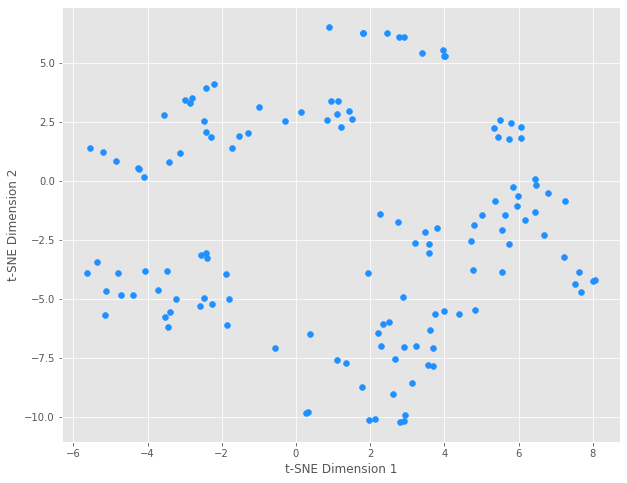

In [113]:
# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2)
tsne_latents = tsne.fit_transform(latents)

plt.figure(figsize=(10, 8))
plt.scatter(tsne_latents[:, 0], tsne_latents[:, 1], color='dodgerblue')
# plt.xlim(-400, 400)
# plt.ylim(-400, 400)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

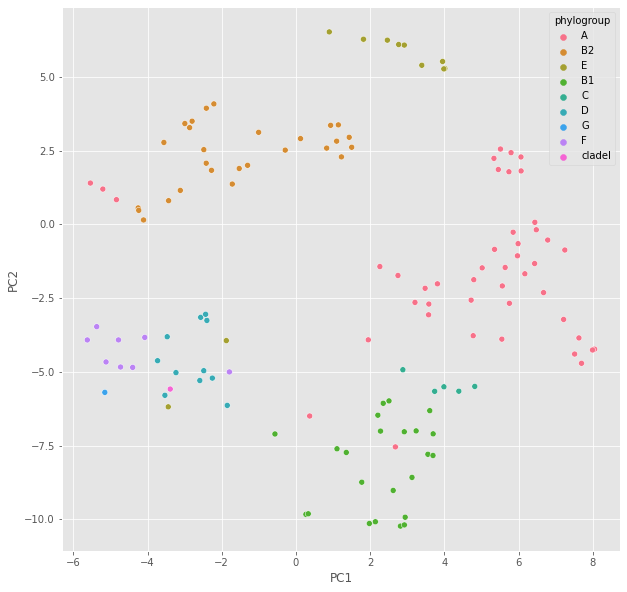

In [118]:
df_tsne = pd.DataFrame(tsne_latents, columns=['PC1', 'PC2'])
df_tsne['phylogroup'] = test_phylogroups
plt.figure(figsize=(10, 10))
sns.scatterplot(x='PC1', y='PC2', hue = df_tsne['phylogroup'], data=df_tsne)
plt.savefig("figures/tsne_latent_space_visualisation.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [110]:
# Apply PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(latents)
df_pca = pd.DataFrame(data_pca, columns=['PC1', 'PC2'])
df_pca['phylogroup'] = test_phylogroups


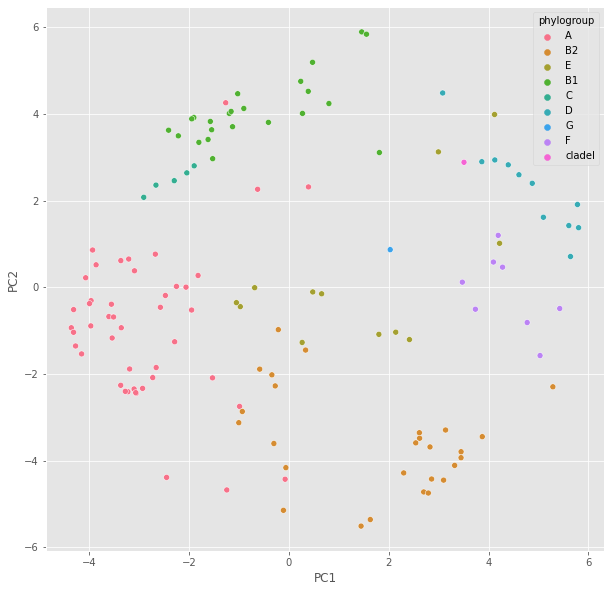

In [112]:
# Plot the PCA results
plt.figure(figsize=(10, 10))
sns.scatterplot(x='PC1', y='PC2', hue = df_pca['phylogroup'], data=df_pca)
plt.savefig("figures/pca_latent_space_visualisation.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [108]:
df_pca

,PC1,PC2,phylogroup
0,-2.476008,-0.186472,A
1,-0.301694,-3.603904,B2
2,-1.820895,0.275081,A
3,1.801965,-1.083667,E
4,-3.094970,0.382702,A
...,...,...,...
128,3.319992,-4.109268,B2
129,4.119271,3.991544,E
130,-3.278590,-2.399727,A
131,-3.069809,-2.430137,A


# 5) Reconstruction/generation (evaluation) (to do later, just a test for now)

In [40]:
# Load trained model 
model = VAE(input_dim, hidden_dim, latent_dim)
model.load_state_dict(torch.load('saved_KL_annealing_VAE_100.pt'))  
model.eval()  

# Generate 10 new samples
num_samples = 10 
with torch.no_grad():
    z = torch.randn(num_samples, latent_dim)  # Sample from the standard normal distribution (????)
    generated_samples = model.decode(z).cpu().numpy() 

threshold = 0.5
binary_generated_samples = (generated_samples > threshold).astype(float)

print("Generated samples:\n", binary_generated_samples)
print("Generated samples:\n", generated_samples)


FileNotFoundError: [Errno 2] No such file or directory: 'saved_KL_annealing_VAE_100.pt'

# 6) Hyperparameter tuning

## 6.1) Gridserch for simple hyperparameter tuning

In [ ]:
# # Gridsearch
# input_dim = data_array_t.shape[1]
# hidden_dim_values = [256, 512, 1024]
# latent_dim_values = [32, 64, 128]
# learning_rate_values = [0.01, 1e-3] # Decrease of learning rate causes higher average train loss, better if 0.01, 0.001
# # beta_start_values = [0.01, 0.1, 0.2]
# # beta_end_values = [0.5, 1.0, 2.0]
# # max_norm_values = [0.5, 1.0, 2.0]
# max_norm = 1.0 
# beta_start = 0.1
# beta_end = 1.0

# # beta_start, beta_end, max_norm
# for hidden_dim, latent_dim, learning_rate in itertools.product(
#     hidden_dim_values, latent_dim_values, learning_rate_values): #beta_start_values, beta_end_values, max_norm_values
#     print(f"Training with hidden_dim={hidden_dim}, latent_dim={latent_dim}, learning_rate={learning_rate}") # beta_start={beta_start}, beta_end={beta_end}, max_norm={max_norm}"
#     model = VAE(input_dim, hidden_dim, latent_dim).to(device)
#     optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
#     train_with_KL_annelaing(model=model, optimizer=optimizer, scheduler=scheduler, n_epochs=10, train_loader=train_loader, val_loader=val_loader, beta_start=beta_start, beta_end=beta_end, max_norm=max_norm)
#     print("--------------------------------------------------------------------------------------")

### result - best params hidden_dim = 1024, latent_dim = 32, lr = 1e-3 (based on average train and val loss)

In [ ]:
input_dim = data_array_t.shape[1]
hidden_dim = 1024
latent_dim = 32
max_norm = 1.0 
beta_start = 0.1
beta_end = 1.0
n_epochs = 100


model = VAE(input_dim, hidden_dim, latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

train_loss_vals2, val_loss_vals = train_with_KL_annelaing(model=model, optimizer=optimizer, scheduler=scheduler, n_epochs=n_epochs, train_loader=train_loader, val_loader=val_loader, beta_start=beta_start, beta_end=beta_end, max_norm=max_norm)

In [ ]:
torch.save(model.state_dict(), "models/saved_KL_annealing_VAE_tuned_100.pt")
print("Model saved.")

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(epochs, train_loss_vals2, color='dodgerblue')
plt.plot(epochs, train_loss_vals2, label='Train Loss', color='dodgerblue')
plt.scatter(epochs, val_loss_vals, color='darkorange')
plt.plot(epochs, val_loss_vals, label='Validation Loss', color='darkorange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# AHPT - after hyperparameter tuning
plt.savefig("figures/train_val_loss_AHPT_100.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
latents = get_latent_variables(model, train_loader, device)
pca = PCA(n_components=2)
data_pca = pca.fit_transform(latents)
df_pca = pd.DataFrame(data_pca, columns=['PC1', 'PC2'])

In [ ]:
# Visualize the first two principal components
plt.figure(figsize=(10, 10))
sns.scatterplot(x='PC1', y='PC2', data=df_pca, color='dodgerblue')
# plt.xlim(-5, 5)
# plt.ylim(-5, 5)
# AHPT - after hyperparameter tuning
plt.savefig("figures/pca_latent_space_visualisation_AHPT.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
len(latents)

In [ ]:
# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2)
data_tsne = tsne.fit_transform(latents)

In [ ]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(data_tsne[:, 0], data_tsne[:, 1], color='dodgerblue')
# plt.xlim(-20, 20)
# plt.ylim(-20, 20)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
# AHPT - after hyperparameter tuning
plt.savefig("figures/tsne_latent_space_visualisation_AHPT.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
len(data_tsne)

# 7) Evaluation test 

In [ ]:
model = VAE(input_dim, hidden_dim, latent_dim)
model.load_state_dict(torch.load('saved_KL_annealing_VAE_tuned_100.pt'))  

model.eval()
with torch.no_grad():
    recon_x, mu, logvar = model(test_data)

recon_x_binarized = (recon_x > 0.5).int()

f1 = sklearn.metrics.f1_score(test_data.flatten(), recon_x_binarized.flatten())
print(f'F1 Score: {f1:.2f}')

In [ ]:
recon_x_binarized = (recon_x > 0.5).int()

f1_scores = []
for genome_x, genome in zip(recon_x_binarized, test_data):
    f1_scores.append(sklearn.metrics.f1_score(genome_x, genome))

In [ ]:
type(test_data)

In [ ]:
plt.figure(figsize=(10,8))
plt.hist(f1_scores, color='dodgerblue')
plt.xlabel("F1 score")
plt.ylabel("Frequency")
plt.savefig("figures/f1_score_frequency_test_set.pdf", format="pdf", bbox_inches="tight")
plt.show()